Physics‑informed neural network (PINN) demonstration for a
time‑varying autoregressive (TVAR) process with a constant
sliding‑window power constraint.

This script implements a complete workflow for

1. **Simulating a signal** generated by a TVAR(p) model whose
   coefficients vary smoothly over time.  To mimic a physical
   constraint, the amplitude of the simulated signal is scaled at
   each time step so that the mean power in a window of length
   ``W`` samples is constant.  The simulation therefore produces a
   non‑stationary sequence whose local energy does not vary.

2. **Designing a PINN model** to estimate the latent
   time‑dependent AR coefficients from the observed signal.  A
   small feed‑forward neural network maps the (normalised) time
   index to a vector of AR coefficients.  The network is trained by
   minimizing a composite loss consisting of:

   * An **autoregressive residual** term measuring how well the
     predicted coefficients reproduce the signal when used in an
     AR(p) recursion.  This encourages the network to encode the
     correct linear dependence structure.

   * A **windowed power penalty** enforcing that the mean squared
     amplitude of the network’s autoregressive prediction remains
     close to the known constant power ``P0``.  This term is the
     soft form of the physics constraint that the signal energy is
     constant over a sliding window.

   * A **smoothness regulariser** on the estimated coefficient
     trajectories.  Since the true coefficients vary smoothly, this
     penalty discourages abrupt changes in the learned functions.

3. **Training** the network with manual gradient descent.  The
   gradients of all loss components with respect to network
   parameters are computed explicitly using the chain rule, without
   relying on external automatic differentiation libraries.  This
   makes the code fully self‑contained and illustrates how PINN
   training proceeds under the hood.

4. **Visualising** the results.  The script produces figures
   showing the simulated signal, its sliding‑window power, the
   evolution of the loss terms during training, and a comparison of
   the true and learned AR coefficients.  Due to the simplicity of
   the network and limited training iterations the estimates will
   generally approximate only the broad trend of the true
   coefficients.  Nevertheless the example demonstrates how
   physical constraints can be incorporated into time series
   modelling via a PINN‑style framework.

The code uses only NumPy and Matplotlib; it does not depend on
deep‑learning frameworks such as PyTorch or TensorFlow.  It is
intended for educational purposes and can be run as a standalone
script or inside a Jupyter notebook.

Epoch  80 / 800, total loss = 1.7774, AR = 1.4178, energy = 0.3596, smooth = 0.0000
Epoch 160 / 800, total loss = 1.7723, AR = 1.4541, energy = 0.3182, smooth = 0.0000
Epoch 240 / 800, total loss = 1.7704, AR = 1.4573, energy = 0.3131, smooth = 0.0000
Epoch 320 / 800, total loss = 1.7695, AR = 1.4589, energy = 0.3106, smooth = 0.0000
Epoch 400 / 800, total loss = 1.7691, AR = 1.4597, energy = 0.3094, smooth = 0.0000
Epoch 480 / 800, total loss = 1.7689, AR = 1.4602, energy = 0.3087, smooth = 0.0000
Epoch 560 / 800, total loss = 1.7688, AR = 1.4604, energy = 0.3083, smooth = 0.0000
Epoch 640 / 800, total loss = 1.7687, AR = 1.4606, energy = 0.3081, smooth = 0.0000
Epoch 720 / 800, total loss = 1.7686, AR = 1.4606, energy = 0.3080, smooth = 0.0000
Epoch 800 / 800, total loss = 1.7686, AR = 1.4607, energy = 0.3079, smooth = 0.0000

Estimated model order p: 2
In this demonstration the time scale τ governing coefficient smoothness is not learned explicitly; its effect is controlled by the s

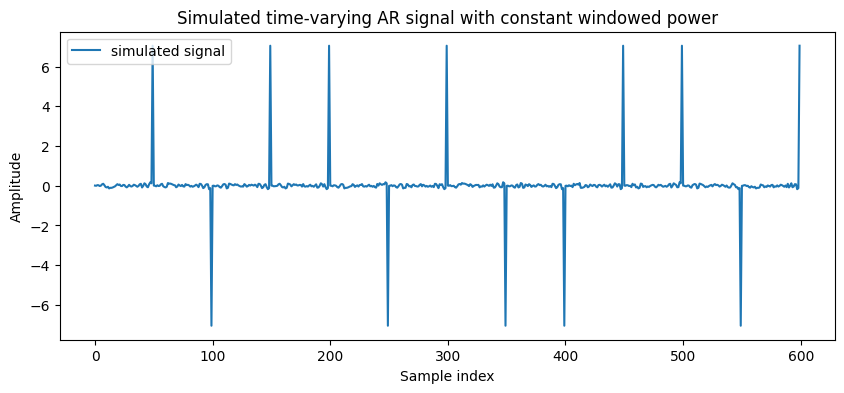

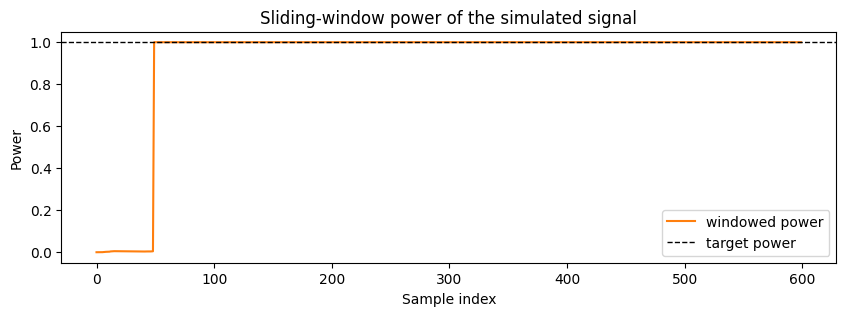

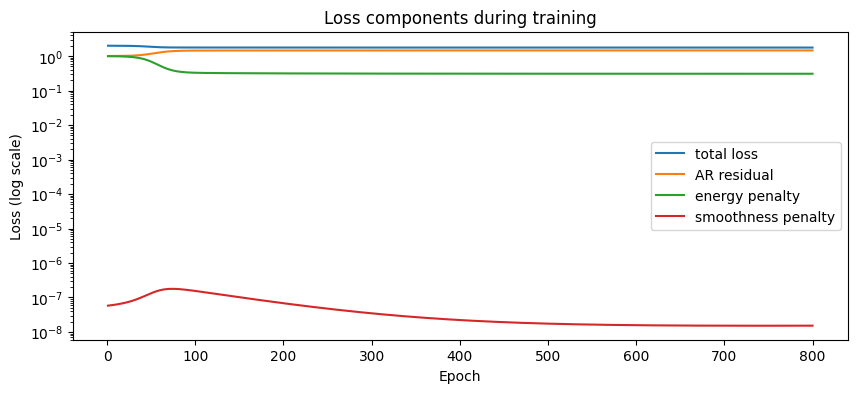

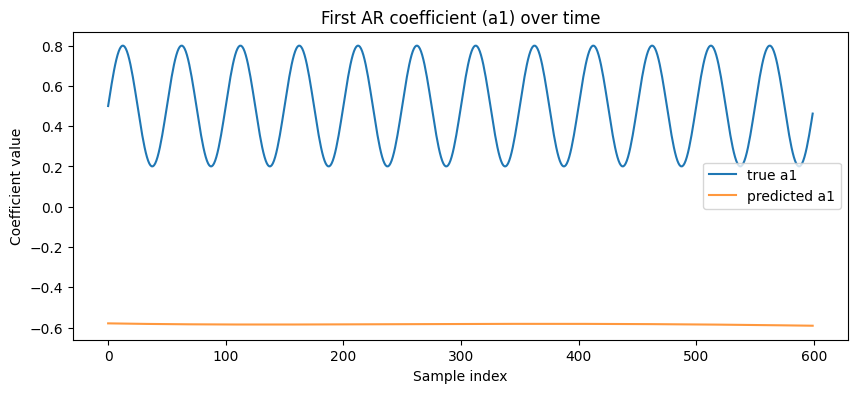

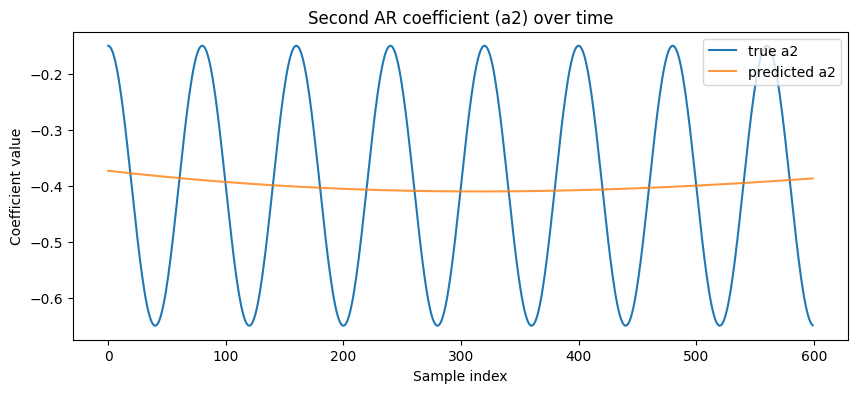

In [8]:

import numpy as np
import matplotlib.pyplot as plt


def simulate_tvar_constant_power(N: int, p: int, W: int, P0: float,
                                 coeff_funcs, noise_std: float = 0.05,
                                 seed: int = 0):
    """Generate a length‑N time‑varying AR(p) sequence with constant
    sliding‑window power.

    Parameters
    ----------
    N : int
        Length of the signal to generate.
    p : int
        Order of the autoregressive model.
    W : int
        Length of the sliding window used to enforce constant power.
    P0 : float
        Desired constant power (mean squared amplitude) within each
        window of length ``W``.
    coeff_funcs : list of callables
        List of length ``p``.  The k‑th element is a function of
        integer time ``t`` returning the AR coefficient ``a_{k}(t)``.
    noise_std : float, optional
        Standard deviation of the additive white noise driving the
        process.  Default is 0.05.
    seed : int, optional
        Seed for the random number generator.  Default is 0 (for
        reproducibility).

    Returns
    -------
    x_scaled : ndarray of shape (N,)
        The simulated signal whose sliding‑window power equals ``P0``.
    coeffs_true : ndarray of shape (N, p)
        Array of the true time‑varying coefficients evaluated at
        each time index.
    """
    rng = np.random.default_rng(seed)
    x_raw = np.zeros(N)
    x_scaled = np.zeros(N)
    coeffs_true = np.zeros((N, p))
    for t in range(N):
        coeffs_true[t] = [func(t) for func in coeff_funcs]
    S_prev = 0.0  # sliding sum of squared amplitudes for previous W−1 samples
    for t in range(N):
        # generate raw sample from AR with scaled past values
        val = rng.normal(scale=noise_std)
        for k in range(1, p + 1):
            if t >= k:
                val += coeffs_true[t, k - 1] * x_scaled[t - k]
        x_raw[t] = val
        # update sliding sum for scaled signal
        if t == 0:
            S_prev = 0.0
        else:
            if t < W:
                S_prev = np.sum(x_scaled[:t] ** 2)
            else:
                S_prev = S_prev + x_scaled[t - 1] ** 2 - x_scaled[t - W] ** 2
        # compute scaling factor so that new window energy matches P0
        if t >= W - 1:
            target_energy = P0 * W
            denom = x_raw[t] ** 2 + 1e-12  # avoid divide by zero
            c_sq = max((target_energy - S_prev) / denom, 0.0)
            c = np.sqrt(c_sq)
        else:
            c = 1.0
        x_scaled[t] = c * x_raw[t]
    return x_scaled, coeffs_true


class SimplePINN:
    """A minimalist two‑hidden‑layer neural network for time‑varying AR coefficients."""
    def __init__(self, p: int, h1: int = 20, h2: int = 20, seed: int = 0):
        rng = np.random.default_rng(seed)
        self.W1 = rng.normal(scale=0.5, size=(1, h1))
        self.b1 = np.zeros(h1)
        self.W2 = rng.normal(scale=0.5, size=(h1, h2))
        self.b2 = np.zeros(h2)
        self.W3 = rng.normal(scale=0.5, size=(h2, p))
        self.b3 = np.zeros(p)
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    @staticmethod
    def dtanh(x):
        return 1.0 - np.tanh(x) ** 2
    def forward(self, t: np.ndarray):
        z1 = t @ self.W1 + self.b1
        h1_act = self.tanh(z1)
        z2 = h1_act @ self.W2 + self.b2
        h2_act = self.tanh(z2)
        out = h2_act @ self.W3 + self.b3
        cache = {
            "t": t,
            "z1": z1,
            "h1": h1_act,
            "z2": z2,
            "h2": h2_act,
            "out": out,
        }
        return out, cache
    def backward(self, cache: dict, dL_dout: np.ndarray):
        z1, h1_act = cache["z1"], cache["h1"]
        z2, h2_act = cache["z2"], cache["h2"]
        t = cache["t"]
        M = dL_dout.shape[0]
        dW3 = np.zeros_like(self.W3)
        db3 = np.zeros_like(self.b3)
        dW2 = np.zeros_like(self.W2)
        db2 = np.zeros_like(self.b2)
        dW1 = np.zeros_like(self.W1)
        db1 = np.zeros_like(self.b1)
        for i in range(M):
            g_c = dL_dout[i]
            h2_i = h2_act[i]
            dW3 += np.outer(h2_i, g_c)
            db3 += g_c
            g_h2 = g_c @ self.W3.T
            g_z2 = g_h2 * self.dtanh(z2[i])
            h1_i = h1_act[i]
            dW2 += np.outer(h1_i, g_z2)
            db2 += g_z2
            g_h1 = g_z2 @ self.W2.T
            g_z1 = g_h1 * self.dtanh(z1[i])
            t_i = t[i, 0]
            dW1 += t_i * g_z1.reshape(1, -1)
            db1 += g_z1
        grads = {
            "W1": dW1,
            "b1": db1,
            "W2": dW2,
            "b2": db2,
            "W3": dW3,
            "b3": db3,
        }
        return grads
    def step(self, grads: dict, lr: float):
        self.W1 -= lr * grads["W1"]
        self.b1 -= lr * grads["b1"]
        self.W2 -= lr * grads["W2"]
        self.b2 -= lr * grads["b2"]
        self.W3 -= lr * grads["W3"]
        self.b3 -= lr * grads["b3"]


def train_pinn(x: np.ndarray, p: int, W: int, P0: float, n_epochs: int = 400,
               lr: float = 0.01, lambda_energy: float = 1.0,
               lambda_smooth: float = 0.1, seed: int = 0):
    N = len(x)
    M = N - p
    t_vals = np.linspace(0.0, 1.0, N)
    train_t = t_vals[p:].reshape(-1, 1)
    pinn = SimplePINN(p=p, seed=seed)
    hist_total, hist_ar, hist_energy, hist_smooth = [], [], [], []
    for epoch in range(n_epochs):
        out, cache = pinn.forward(train_t)
        x_hat = np.zeros(M)
        residuals = np.zeros(M)
        for idx in range(M):
            t_idx = p + idx
            past_vals = np.array([x[t_idx - k] for k in range(1, p + 1)])
            coeffs = out[idx]
            x_hat[idx] = np.dot(coeffs, past_vals)
            residuals[idx] = x[t_idx] - x_hat[idx]
        loss_ar = np.mean(residuals ** 2)
        P_hat = np.zeros(M)
        for i in range(M):
            start = max(0, i - W + 1)
            window = x_hat[start:i + 1]
            P_hat[i] = np.mean(window ** 2) if window.size > 0 else 0.0
        r_en = P_hat - P0
        loss_energy = np.mean(r_en ** 2)
        diff = out[1:] - out[:-1]
        loss_smooth = np.mean(np.sum(diff ** 2, axis=1))
        loss_total = loss_ar + lambda_energy * loss_energy + lambda_smooth * loss_smooth
        hist_total.append(loss_total)
        hist_ar.append(loss_ar)
        hist_energy.append(loss_energy)
        hist_smooth.append(loss_smooth)
        # compute gradient w.r.t. network output
        dL_dout = np.zeros_like(out)
        for idx in range(M):
            t_idx = p + idx
            past_vals = np.array([x[t_idx - k] for k in range(1, p + 1)])
            dL_dout[idx] += (-2.0 / M) * residuals[idx] * past_vals
        dL_dPhat = (2.0 / M) * r_en
        dL_d_xhat = np.zeros(M)
        for j in range(M):
            i_start = j
            i_end = min(M - 1, j + W - 1)
            if i_end >= i_start:
                s = np.sum(dL_dPhat[i_start:i_end + 1])
                dL_d_xhat[j] = s * (2.0 / W) * x_hat[j]
        for j in range(M):
            t_idx = p + j
            past_vals = np.array([x[t_idx - k] for k in range(1, p + 1)])
            dL_dout[j] += lambda_energy * dL_d_xhat[j] * past_vals
        for k in range(M):
            grad = np.zeros(p)
            if k < M - 1:
                grad -= (out[k + 1] - out[k])
            if k > 0:
                grad += (out[k] - out[k - 1])
            dL_dout[k] += (2.0 * lambda_smooth / M) * grad
        grads = pinn.backward(cache, dL_dout)
        pinn.step(grads, lr)
        if (epoch + 1) % max(1, (n_epochs // 10)) == 0:
            print(f"Epoch {epoch + 1:3d} / {n_epochs}, total loss = {loss_total:.4f}, "
                  f"AR = {loss_ar:.4f}, energy = {loss_energy:.4f}, smooth = {loss_smooth:.4f}")
    history = {
        "total": hist_total,
        "ar": hist_ar,
        "energy": hist_energy,
        "smooth": hist_smooth,
    }
    return pinn, history


def main():
    N = 600
    p = 2
    W = 50
    P0 = 1.0
    n = np.arange(N)
    freq1, freq2 = 1 / 50, 1 / 80
    a1_func = lambda t: 0.5 + 0.3 * np.sin(2 * np.pi * freq1 * t)
    a2_func = lambda t: -0.4 + 0.25 * np.cos(2 * np.pi * freq2 * t)
    coeff_funcs = [a1_func, a2_func]
    x, coeffs_true = simulate_tvar_constant_power(N, p, W, P0, coeff_funcs)
    plt.figure(figsize=(10, 4))
    plt.plot(x, label="simulated signal")
    plt.title("Simulated time‑varying AR signal with constant windowed power")
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.legend()
    power = np.zeros(N)
    for i in range(N):
        start = max(0, i - W + 1)
        window = x[start:i + 1]
        power[i] = np.mean(window ** 2)
    plt.figure(figsize=(10, 3))
    plt.plot(power, color="tab:orange", label="windowed power")
    plt.axhline(P0, color="k", linestyle="--", linewidth=1, label="target power")
    plt.title("Sliding‑window power of the simulated signal")
    plt.xlabel("Sample index")
    plt.ylabel("Power")
    plt.legend()
    pinn, history = train_pinn(x, p, W, P0, n_epochs=800, lr=0.001,
                               lambda_energy=1.0, lambda_smooth=0.1, seed=1)
    t_vals = np.linspace(0, 1, N).reshape(-1, 1)
    coeffs_pred, _ = pinn.forward(t_vals)
    epochs = np.arange(1, len(history["total"]) + 1)
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["total"], label="total loss")
    plt.plot(epochs, history["ar"], label="AR residual")
    plt.plot(epochs, history["energy"], label="energy penalty")
    plt.plot(epochs, history["smooth"], label="smoothness penalty")
    plt.yscale('log')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (log scale)")
    plt.title("Loss components during training")
    plt.legend()
    plt.figure(figsize=(10, 4))
    plt.plot(coeffs_true[:, 0], label="true a1")
    plt.plot(coeffs_pred[:, 0], label="predicted a1", alpha=0.8)
    plt.title("First AR coefficient (a1) over time")
    plt.xlabel("Sample index")
    plt.ylabel("Coefficient value")
    plt.legend()
    plt.figure(figsize=(10, 4))
    plt.plot(coeffs_true[:, 1], label="true a2")
    plt.plot(coeffs_pred[:, 1], label="predicted a2", alpha=0.8)
    plt.title("Second AR coefficient (a2) over time")
    plt.xlabel("Sample index")
    plt.ylabel("Coefficient value")
    plt.legend()
    print(f"\nEstimated model order p: {p}")
    print("In this demonstration the time scale τ governing coefficient "
          "smoothness is not learned explicitly; its effect is controlled by "
          "the smoothness penalty weight λ_smooth = 0.1.")


if __name__ == "__main__":
    main()